<a href="https://colab.research.google.com/github/PetchMa/deeplearning_fundamentals/blob/main/Image_GCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Convolutional Graph Neural Network

In this notebook we will try and build a graph based neural network for image data. In other words we have entire image data instead of feature vectors. This will use both ```JAX``` and ```HAIKU``` to write this neural network!

In [1]:
!pip install dm-haiku
!pip install jraph

In [2]:
import jax
import jax.numpy as jnp
import haiku as hk
import numpy as np
import matplotlib.pyplot as plt
import jraph
from jax import vmap, grad, jit
%matplotlib inline

# Data

First let us understand how the data will appear we will have an adjacency matrix to represent the graph structure, then we will have a 2-d image which are the inital 64 features of the data strucutre. Note that to get the dimensions align we need to "upgrade" the adjacency matrix with multiple copies of it self along the "columns" of our images thus the entire image is passed in the same way. 



In [3]:
seed = 0
rng = jax.random.PRNGKey(seed)
# data = jax.random.normal(rng, shape=(64, 16,16))
data =np.zeros((64, 16,256))
print(data.shape)


adj_matrix =  jnp.ones((64,64))
# adj_matrix = jax.random.normal(rng, shape=(64, 64,16))

(64, 16, 256)


# Update Nodes
We can preform message passing and message aggregation in the SAME line giving us the following. We can double check that this is in fact doing what we wanted to do by looking at the following images - note we divide by 64 just to keep the data normalized.

To implement this we run this test, we have dots painted on each of the 64 tiles of the image and to correctly aggregate the data we want to sum up the features where there exists a connection! We are going to connect every node and if this works, it would produce a diagonal thus the data of adjacent nodes have succesfully been passed to this node. In order to speed this up we're going to 

In [4]:
def update_features(features, adj_matrix):
  updated_features = np.zeros(features.shape)
  for i in range(features.shape[-1]):
    updated_features[:,:,i] = jnp.matmul(adj_matrix[:,:],features[:,:,i])
  return jnp.array(updated_features)/updated_features.max()

updated_features = update_features(data, adj_matrix)
print(updated_features.shape)

(64, 16, 256)


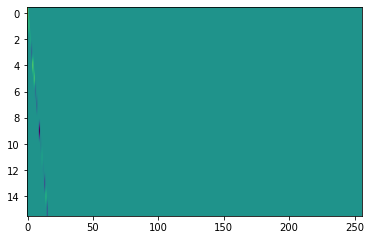

In [5]:
for i in range(16):
  data[i,i,i]=10000

adj_matrix = jax.random.normal(rng, shape=(64, 64))
updated_features = update_features(data, adj_matrix)

plt.imshow(updated_features[0,:,:], aspect=10)

In [6]:
%timeit update_features(data, adj_matrix)

1 loop, best of 5: 451 ms per loop


# Vectorization
Okay cool we have something that works but we need to vectorize this to make it run fast this is how we do it. Note that this screws up the ordering the of data shape and so we will reshape it. This is important as it is ```28x``` the speed and preformance.

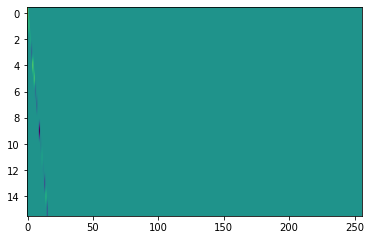

In [7]:
def update_node(adj_matrix, data):
  def update_row(adj_matrix, row):
    return jnp.matmul(adj_matrix, row)
  update_data = vmap(update_row, in_axes=(None, 1))(adj_matrix, data)
  return jnp.swapaxes(update_data, 0,1)/update_data.max()

updated_features = update_node(adj_matrix,data)

plt.imshow(updated_features[0,:,:], aspect=10)

In [8]:
%timeit update_node(adj_matrix,data)

100 loops, best of 5: 3.16 ms per loop


# Vectorization Again...
Okay cool we solved the problme for a single graph but now we have to vectroize the model once again to handle batches.

In [9]:
num_samples =128
data_batch =np.zeros((num_samples, 64, 16, 256))
adj_matrix_batch =  jnp.ones((num_samples, 64,64))

batch_update_node =  vmap(update_node, in_axes=(0, 0))
test = batch_update_node( adj_matrix_batch, data_batch)
print(test.shape)

(128, 64, 16, 256)


In [10]:
batch_updated = vmap(update_node, in_axes=(0, 0))(adj_matrix_batch, data_batch)

test = batch_update_node( adj_matrix_batch, data_batch)

# Network Architecture

We can now start trying to build the neural network Architecture using this helper function. We recall that we want to slide in a convolutional operation to make a collective classification. Now we will use the great magical powers of HAIKU

In [15]:
class image_graph(hk.Module):

  def __init__(self, adj_matrix, aggregation_func, name=None):
    super().__init__(name=name)
    self.adj_matrix = adj_matrix
    self.aggregation_func = aggregation_func
  
  def update_node(self,adj_matrix, data):
    def update_row(adj_matrix, row):
      return jnp.matmul(adj_matrix, row)
    update_data = vmap(update_row, in_axes=(None, 1))(adj_matrix, data)
    return jnp.swapaxes(update_data, 0,1)/update_data.max()
  
  def batch_updated_node(self, adj_matrix_batch, data_batch):
    return vmap(update_node, in_axes=(0, 0))(adj_matrix_batch, data_batch)

  def __call__(self, x):
    x = self.batch_updated_node(self.adj_matrix, x)
    x = jax.nn.relu(x)
    return x



# Double Check
Let us just double check the custom layer works the way we intend it to work


In [16]:
def test_model(adj_matrix, x):
  image_graph_layer = image_graph(adj_matrix, batch_update_node)
  return image_graph_layer(x)

test_model1 = hk.transform(test_model)

params = test_model1.init(rng,adj_matrix_batch, x=data_batch)

update = test_model1.apply(params=params,adj_matrix =adj_matrix_batch, x=data_batch, rng=rng)

# Define Feedforward
We can now define the feedforward model for 

In [42]:

def forward_model(adj_matrix, x):
  image_graph_layer = image_graph(adj_matrix, batch_update_node)
  conv3d_1 = hk.Conv3D(64,kernel_shape=(3,3,3))

  max_pool = hk.MaxPool(window_shape = (4,1,4),  strides=1, padding='VALID')
  flatten = hk.Flatten()
  
  for i in range(10):
    initial = x 
    x = image_graph_layer(x)
    x = jnp.swapaxes(x,3, 1 )
    x = conv3d_1(x)
    x = jax.nn.relu(x)
    x = jnp.swapaxes(x,3, 1 )
    x = x+ initial

  x = max_pool(x)

  x = flatten(x)
  x = jax.nn.relu(x)
  mlp_input = x.shape[0]
  fully_connected = hk.nets.MLP([mlp_input, 256, 128, 64], )
  x = fully_connected(x)

  return x


model_forward= hk.transform(forward_model)
data_batch =np.zeros((num_samples, 64, 16, 256))
adj_matrix_batch =  jnp.ones((num_samples, 64,64))
params = model_forward.init(rng,adj_matrix_batch, x=data_batch)
update = model_forward.apply(params=params,adj_matrix =adj_matrix_batch, x=data_batch, rng=rng)